In [1]:
import numpy as np
import pandas as pd
import cmdstanpy 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import os
import json
from Utils.random import simulate_ANN_RDM_full_s
from Utils.utils import hdi
from scipy.stats import gaussian_kde
import ipywidgets as widgets

ModuleNotFoundError: No module named 'Utils'

In [2]:
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["pdf.use14corefonts"] = True

In [3]:
root = "./"
plots_root = root + "Plots/Parameter Recovery"
datasets_root = root + "Datasets/"
behavioural_data_root = root +  "behavioral_data/selected_data/" 
stan_files_root = root +  "stan files/" 
saved_models_root = root + "stan_results/Parameter Recovery"
dataset_path = datasets_root + "fastText_FC.csv"

In [ ]:
number_of_participants = 4
number_of_parameters = 8
number_of_iteration = 4
n_trials = 100

## Funtions

In [4]:
def generate_parameter_set(number_of_participants,  number_of_parameters):
    # Prior ranges for the simulator
    # alpha ~ U(0.1, 5.0)
    # b ~ U(0.1, 5.0)
    # k_1 ~ U(0.1, 5.0)  # relative start point
    # k_2 ~ U(0.1, 5.0)
    # threshold_word ~ U(2.0, 8.0)
    # threshold_nonword ~ U(2.0, 8.0)
    # ndt ~ U(0.01, 2)

    return np.random.uniform(low=(0.1, 0.1, 0.1, 0.1, 2.0, 2.0, 0.01),
                                      high=(5.0, 5.0, 5.0, 5.0, 8.0, 8.0, 1.0),
                                      size=(number_of_participants, number_of_parameters))

In [1]:
# set sampling parameters
n_iter = 500
n_warmup = int(n_iter/2)
n_sample = int(n_iter/2)
n_chains = 2

threshold_priors = [0, 1, 1, 1]          # For all models with LBA
g_priors = [-2, 1, 0, 1]                 # For models wtih non-decision time modulation
m_priors = [0, 0.5, 0, 1]                # For models wtih non-decision time modulation
alpha_priors = [0, 1, 1, 1]              # For models with drift mapping functions
b_priors = [0, 1, 1, 1]                  # For models with drift mapping functions with asymptote modulation and linear models
k_priors = [2, 1, 1, 1]                  # For models with sigmoid drift mapping functions (ANN-EAM models)

def get_stan_parameters(generated_df):
    N = len(generated_df)                                                    # For all models
    participant = generated_df["participant_id"].to_numpy()                     # For all models
    p = generated_df.loc[:, ["word_prob", "non_word_prob"]].to_numpy()       # predicted probabilites of words and non-words, for ANN-EAM models
    frequency = generated_df["zipf"].to_numpy().astype(int)                  # zipf values, for models with non-decision time or drift modulation
    frequencyCondition = generated_df["category"].replace(["HF", "LF", "NW"], [1, 2, 3]).to_numpy() # For models with conditional drift
    response = generated_df["response"].to_numpy().astype(int)               # for all models
    rt = generated_df["rt"].to_numpy()                                       # for all models
    minRT = generated_df["minRT"].to_numpy()                                 # for all models
    RTbound = 0.1                                                              # for all models
    Number_Of_Participants = len(set(behavioral_df["participant_id"]))

    # define input for the model
    data_dict = {"N": N,
                 "L": Number_Of_Participants,
                 "participant": participant,
                 "response": response,
                 "rt": rt,
                 "minRT": minRT,
                 "RTbound": RTbound,
                 "frequency": frequency,
                 "frequencyCondition": frequencyCondition,
                 "threshold_priors": threshold_priors,
                 "g_priors": g_priors,
                 "m_priors": m_priors,
                 "p": p,
                 "alpha_priors": alpha_priors,
                 "b_priors": b_priors,
                 "k_priors": k_priors,
                 }
    return data_dict

In [6]:
def save_results_to_csv(fit, simulation_number):
    columns = {"participant_id":-1,
           "mean_k_1":-1, "HDI_k_1_top":-1, "HDI_k_1_bottom":-1, "real_k_1":-1, "median_k_1":-1,
           "mean_k_2":-1, "HDI_k_2_top":-1, "HDI_k_2_bottom":-1, "real_k_2":-1, "median_k_2":-1,
           "mean_alpha":-1, "HDI_alpha_top": -1, "HDI_alpha_bottom":-1, "real_alpha":-1, "median_alpha":-1,
           "mean_b":-1, "HDI_b_top":-1, "HDI_b_bottom":-1, "real_b":-1, "median_b":-1,
           "mean_m":-1, "HDI_m_top":-1, "HDI_m_bottom":-1, "real_m":-1, "median_m":-1,
           "mean_g":-1, "HDI_g_top":-1, "HDI_g_bottom":-1, "real_g":-1, "median_g":-1,
           "mean_threshold_word":-1, "HDI_threshold_word_top":-1, "HDI_threshold_word_bottom":-1, 
           "real_threshold_word":-1, "median_threshold_word":-1,
           "mean_threshold_nonword":-1, "HDI_threshold_nonword_top":-1, "HDI_threshold_nonword_bottom":-1,
           "real_threshold_nonword":-1, "median_threshold_nonword":-1}
    
    recoverd_df_individual = pd.DataFrame([], columns=columns.keys())
    recoverd_df_group = pd.DataFrame([])
    
    hdi_vals = hdi(fit.stan_variables()["transf_mu_k_1"])
    recoverd_df_group["transf_mu_k_1_bottom"] = [hdi_vals[0]]
    recoverd_df_group["transf_mu_k_1_top"] = [hdi_vals[1]]
    
    hdi_vals = hdi(fit.stan_variables()["transf_mu_k_2"])
    recoverd_df_group["transf_mu_k_2_bottom"] = [hdi_vals[0]]
    recoverd_df_group["transf_mu_k_2_top"] = [hdi_vals[1]]
  
    hdi_vals = hdi(fit.stan_variables()["transf_mu_alpha"])
    recoverd_df_group["transf_mu_alpha_bottom"] = [hdi_vals[0]]
    recoverd_df_group["transf_mu_alpha_top"] = [hdi_vals[1]]
    
    hdi_vals = hdi(fit.stan_variables()["transf_mu_b"])
    recoverd_df_group["transf_mu_b_bottom"] = [hdi_vals[0]]
    recoverd_df_group["transf_mu_b_top"] = [hdi_vals[1]]
    
    hdi_vals = hdi(fit.stan_variables()["transf_mu_threshold_word"])
    recoverd_df_group["transf_mu_threshold_word_bottom"] = [hdi_vals[0]]
    recoverd_df_group["transf_mu_threshold_word_top"] = [hdi_vals[1]]
    
    hdi_vals = hdi(fit.stan_variables()["transf_mu_threshold_nonword"])
    recoverd_df_group["transf_mu_threshold_nonword_bottom"] = [hdi_vals[0]]
    recoverd_df_group["transf_mu_threshold_nonword_top"] = [hdi_vals[1]]
    
    hdi_vals = hdi(fit.stan_variables()["transf_mu_m"])
    recoverd_df_group["transf_mu_m_bottom"] = [hdi_vals[0]] 
    recoverd_df_group["transf_mu_m_top"] = [hdi_vals[1]]
    
    hdi_vals = hdi(fit.stan_variables()["transf_mu_g"])
    recoverd_df_group["transf_mu_g_bottom"] = [hdi_vals[0]] 
    recoverd_df_group["transf_mu_g_top"] = [hdi_vals[1]]
    
    recoverd_df_group['simulation_number']=[simulation_number]
        
    for id in behavioral_df.participant_id.unique():
        columns.clear()
        participant_df = (behavioral_df.loc[behavioral_df["participant_id"]==id]).reset_index(drop=True)
        columns["participant_id"] = id

        columns["mean_k_1"] = fit.stan_variables()["k_1_sbj"][:, id-1].mean()
        columns["median_k_1"] = np.median(fit.stan_variables()["k_1_sbj"][:, id-1])
        columns["real_k_1"] = participant_df.loc[0, "k_1"]
        columns["HDI_k_1_bottom"], columns["HDI_k_1_top"] = hdi(fit.stan_variables()["k_1_sbj"][:, id-1])

        columns["mean_k_2"] = fit.stan_variables()["k_2_sbj"][:, id-1].mean()
        columns["median_k_2"] = np.median(fit.stan_variables()["k_2_sbj"][:, id-1])
        columns["real_k_2"] = participant_df.loc[0, "k_2"]
        columns["HDI_k_2_bottom"], columns["HDI_k_2_top"] = hdi(fit.stan_variables()["k_2_sbj"][:, id-1])

        columns["mean_alpha"] = fit.stan_variables()["alpha_sbj"][:, id-1].mean()
        columns["median_alpha"] = np.median(fit.stan_variables()["alpha_sbj"][:, id-1])
        columns["real_alpha"] = participant_df.loc[0, "alpha"]
        columns["HDI_alpha_bottom"], columns["HDI_alpha_top"] = hdi(fit.stan_variables()["alpha_sbj"][:, id-1])

        columns["mean_b"] = fit.stan_variables()["b_sbj"][:, id-1].mean()
        columns["median_b"] = np.median(fit.stan_variables()["b_sbj"][:, id-1])
        columns["real_b"] = participant_df.loc[0, "b"]
        columns["HDI_b_bottom"], columns["HDI_b_top"] = hdi(fit.stan_variables()["b_sbj"][:, id-1])

        columns["mean_m"] = fit.stan_variables()["m_sbj"][:, id-1].mean()
        columns["median_m"] = np.median(fit.stan_variables()["m_sbj"][:, id-1])
        columns["real_m"] = participant_df.loc[0, "ndt"]
        columns["HDI_m_bottom"], columns["HDI_m_top"] = hdi(fit.stan_variables()["m_sbj"][:, id-1])
        
        columns["mean_g"] = fit.stan_variables()["g_sbj"][:, id-1].mean()
        columns["median_g"] = np.median(fit.stan_variables()["g_sbj"][:, id-1])
        columns["real_g"] = participant_df.loc[0, "g"]
        columns["HDI_g_bottom"], columns["HDI_g_top"] = (hdi(fit.stan_variables()["g_sbj"][:, id-1]))

        columns["mean_threshold_word"] = fit.stan_variables()["threshold_sbj_word"][:, id-1].mean()
        columns["median_threshold_word"] = np.median(fit.stan_variables()["threshold_sbj_word"][:, id-1])
        columns["real_threshold_word"] = participant_df.loc[0, "threshold_word"]
        columns["HDI_threshold_word_bottom"], columns["HDI_threshold_word_top"] = hdi(fit.stan_variables()["threshold_sbj_word"][:, id-1])

        columns["mean_threshold_nonword"] = fit.stan_variables()["threshold_sbj_nonword"][:, id-1].mean()
        columns["median_threshold_nonword"] = np.median(fit.stan_variables()["threshold_sbj_nonword"][:, id-1])
        columns["real_threshold_nonword"] = participant_df.loc[0, "threshold_nonword"]
        columns["HDI_threshold_nonword_bottom"], columns["HDI_threshold_nonword_top"] = hdi(fit.stan_variables()["threshold_sbj_word"][:, id-1])
        
        recoverd_df_individual = pd.concat([recoverd_df_individual, pd.DataFrame(columns, index=[id-1])])
    
    recoverd_df_individual["simulation_number"] = [i]*len(recoverd_df_individual)
    
    output_individual_path='recovery_individual_results.csv'
    recoverd_df_individual.to_csv(output_individual_path, mode='a',
                                  header=not os.path.exists(output_individual_path), index=False)
    output_group_path='recovery_group_results.csv'
    recoverd_df_group.to_csv(output_group_path, mode='a',
                             header=not os.path.exists(output_group_path), index=False)

## Prepare data

In [7]:
word_nword_df = pd.read_csv(dataset_path, header=None,
                            names =["string", "freq",  "label", "zipf",
                                    "category", "word_prob", "non_word_prob"])

In [8]:
rdm_model = cmdstanpy.CmdStanModel(model_name="ANN-RDM_full_FC",
                                   stan_file="stan files/ANN-RDM/sigmoid_am_ndm.stan")

In [9]:
for i in range(number_of_iteration):
    print(f"Iteration {i} Started")
    parameters_set = generate_parameter_set(number_of_participants)
    behavioral_df = simulate_ANN_RDM_full_s(n_trials=n_trials, trials_info_df=word_nword_df,
                                         parameters_set=parameters_set)
    stan_parameters = get_stan_parameters(behavioral_df)
    fit = rdm_model.sample(data=stan_parameters,
                       iter_sampling=n_sample, 
                       iter_warmup=n_warmup,
                       chains=n_chains,
                       show_console=False)
    save_results_to_csv(fit, i)
    print(f"Iteration {i} Finished") 

Iteration 0 Started


19:54:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

19:55:01 - cmdstanpy - INFO - CmdStan done processing.
19:55:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: tmps0jql2of_model_namespace::log_prob: drift_word_t[1] is nan, but must be greater than or equal to 0.000000 (in 'C:/Users/Arash/AppData/Local/Temp/tmpto9l2bv3/tmps0jql2of.stan', line 115, column 4 to column 36)
Consider re-running with show_console=True if the above output is unclear!
19:55:01 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 13 divergent transitions (5.2%)
	Chain 2 had 11 divergent transitions (4.4%)
	Use function "diagnose()" to see further information.



Iteration 0 Finished
Iteration 1 Started


19:55:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

19:55:15 - cmdstanpy - INFO - CmdStan done processing.
19:55:16 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.4%)
	Chain 2 had 1 divergent transitions (0.4%)
	Use function "diagnose()" to see further information.



Iteration 1 Finished


## Particpants parameter recovery

In [10]:
recovery_data = pd.read_csv("recovery_results.csv", header=0)
recovery_data

,participant_id,mean_k_1,HDI_k_1_top,HDI_k_1_bottom,real_k_1,median_k_1,mean_k_2,HDI_k_2_top,HDI_k_2_bottom,real_k_2,...,HDI_threshold_word_top,HDI_threshold_word_bottom,real_threshold_word,median_threshold_word,mean_threshold_nonword,HDI_threshold_nonword_top,HDI_threshold_nonword_bottom,real_threshold_nonword,median_threshold_nonword,simulation_number
0,1,1.878837,3.45372,0.040303,2.670970,1.841890,2.607335,3.80867,1.52363,3.675723,...,5.82057,2.26916,7.763882,3.749000,3.321772,5.82057,2.26916,7.313164,3.156330,0
1,1,3.637644,6.30127,1.180280,3.759797,3.413280,2.065443,3.12755,1.00821,1.429649,...,5.03821,1.97445,4.555452,3.520090,5.230670,5.03821,1.97445,3.462699,5.179930,1
2,1,3.426465,6.10285,0.811471,4.860423,3.352275,2.718580,4.05229,1.50698,4.595920,...,3.59886,1.16104,4.798193,2.306845,3.076986,3.59886,1.16104,5.237114,2.770620,0
3,1,3.795931,7.17790,0.055024,2.402871,3.526635,3.709493,4.95663,2.31095,4.189886,...,4.46850,1.89593,2.363167,3.160840,7.711881,4.46850,1.89593,4.525431,7.536995,1


### Indiviual Level Parameter Recovery

In [28]:
recovery_data = pd.read_csv("recovery_results.csv", header=0)
parameters = ["k_1", "k_2", "alpha", "b", "threshold_word",  "threshold_nonword", "m", "g"] 

### mean

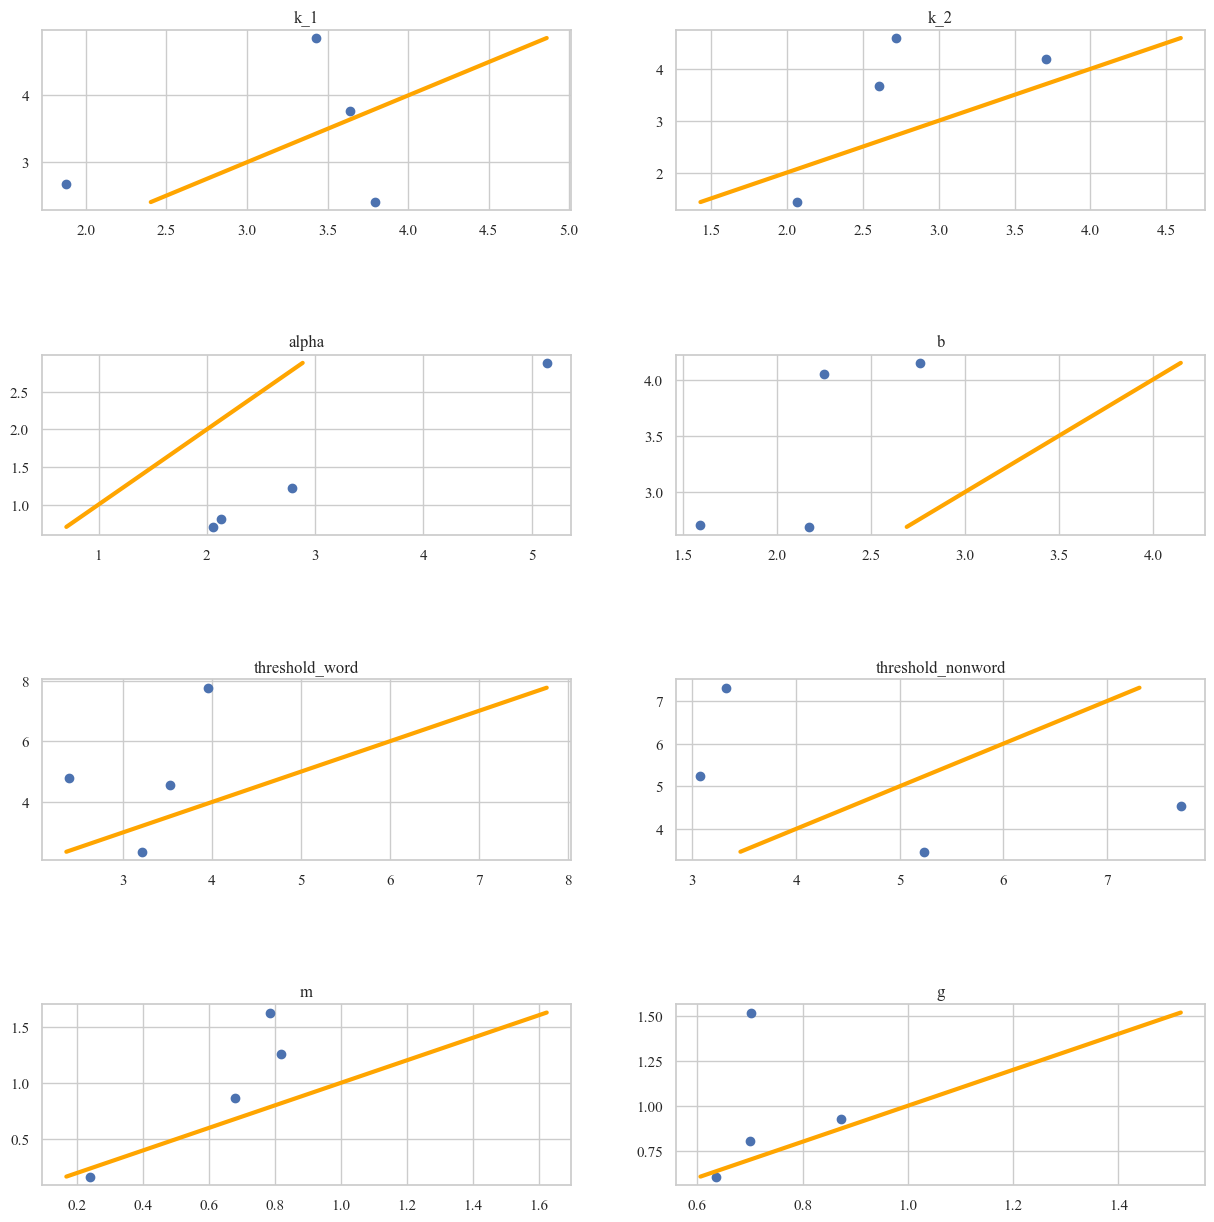

In [33]:
fig, axes = plt.subplots(4, 2, figsize=(15,15))
plt.subplots_adjust(wspace=0.2, hspace=0.8)
raveled_axes = axes.ravel()

for index, parameter in enumerate(parameters):      
    posterior = recovery_data["mean_"+parameter]
    true = recovery_data["real_"+parameter]
    raveled_axes[index].scatter(posterior, true)
    raveled_axes[index].set_title(parameter)
    tempx = np.linspace(recovery_data["real_" + parameter].min(), recovery_data["real_" + parameter].max(), num=100)
    recoverline = raveled_axes[index].plot(tempx, tempx)
    plt.setp(recoverline, linewidth=3, color="orange")

### Median 

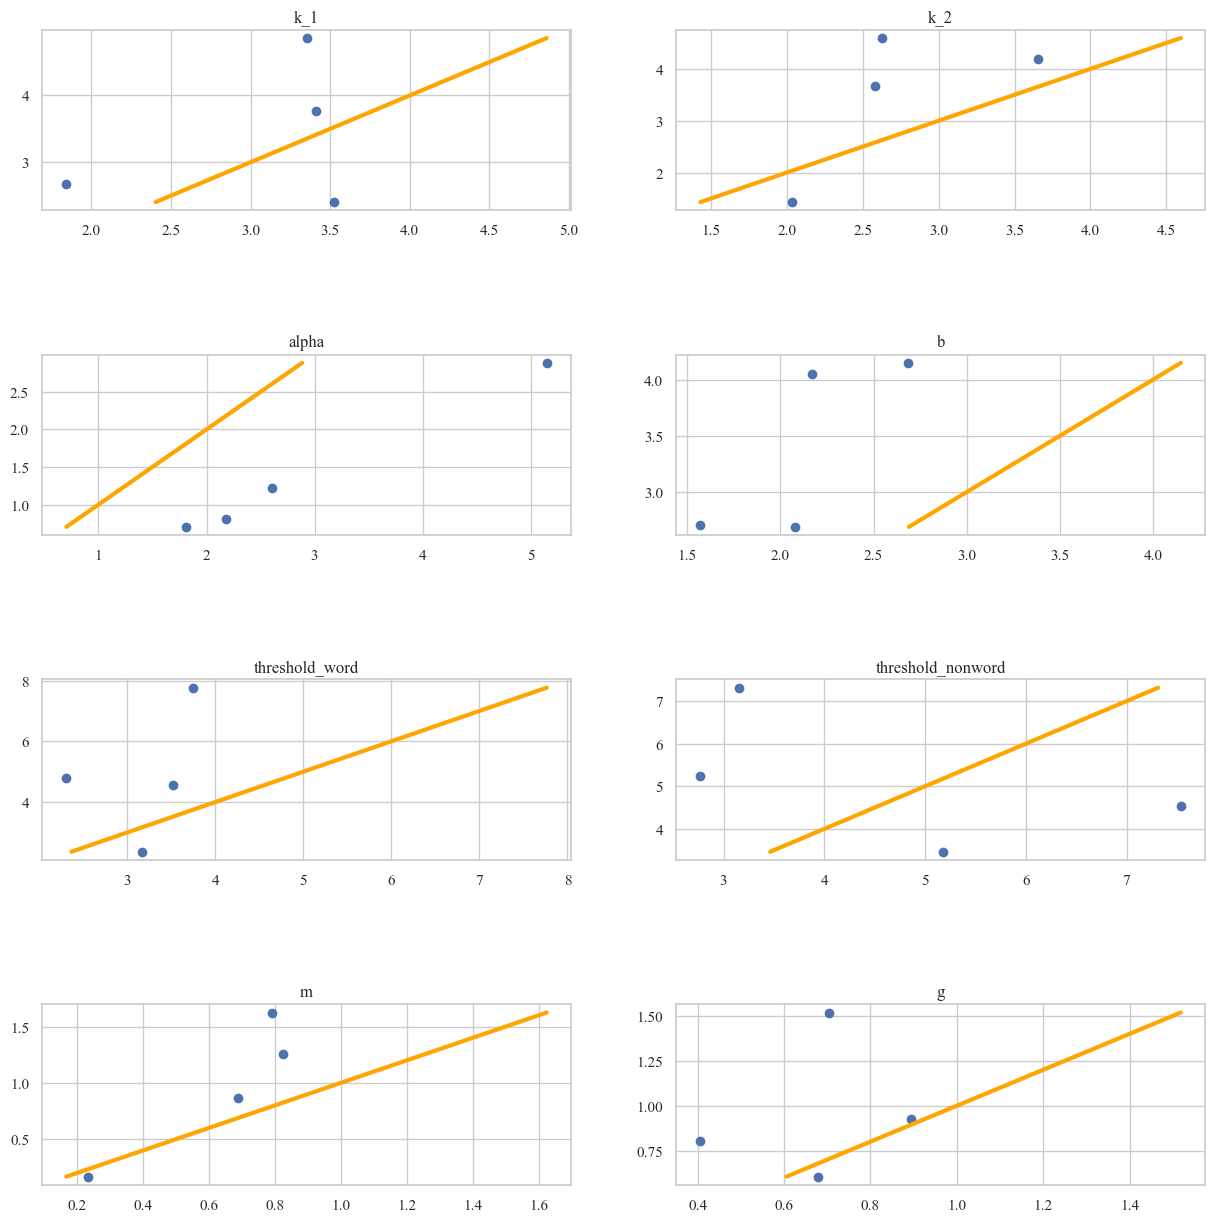

In [34]:
fig, axes = plt.subplots(4, 2, figsize=(15,15))
plt.subplots_adjust(wspace=0.2, hspace=0.8)
raveled_axes = axes.ravel()

for index, parameter in enumerate(parameters):      
    posterior = recovery_data["median_"+parameter]
    true = recovery_data["real_"+parameter]
    raveled_axes[index].scatter(posterior, true)
    raveled_axes[index].set_title(parameter)
    tempx = np.linspace(recovery_data["real_" + parameter].min(), recovery_data["real_" + parameter].max(), num=100)
    recoverline = raveled_axes[index].plot(tempx, tempx)
    plt.setp(recoverline, linewidth=3, color="orange")

### Group level parameter recovery

In [ ]:
axes = az.plot_posterior(fit, var_names="transf_mu_" + behavioral_df.columns[2:10], hdi_prob=.95)

# flatten = axes.flatten()
# for parameter in behavioral_df.columns[2:10]:
#     # flatten[i].axvline(behavioral_df[parameter].mean())
#     flatten[i].axvline(behavioral_df[parameter].mean(),
#               color='red', linestyle='--')
    
flatten = axes.flatten()
for i in range(len(behavioral_df.columns[2:10])):
    flatten[i].axvline(behavioral_df[behavioral_df.columns[2:10]].mean().values[i],
              color='red', linestyle='--')

In [ ]:
ax = sns.scatterplot(data=recoverd_df, x=recoverd_df["mean_alpha"], y=recoverd_df["real_alpha"])
# ax.vlines(x = recoverd_df["mean_k_1"],      # Line on x = 2
#            ymin = recoverd_df['HDI_k_1_bottom'], # Bottom of the plot
#            ymax = recoverd_df['HDI_k_1_top']
#          , colors="red") # Top of the plot
# ax.scatter(recoverd_df["mean_k_1"], recoverd_df["mean_k_1"])

 # Plot line y = x
tempx = np.linspace(recoverd_df["real_alpha"].min(), recoverd_df["real_alpha"].max(), num=100)
recoverline = plt.plot(tempx, tempx)
plt.setp(recoverline, linewidth=3, color="orange")